# IP 3: Predicting production and attraction of trips based on POI's and population density in cities with an xgBoost model.



In [1]:
# Install the packages that are not yet installed of the next block of code
# pip install xgboost
# pip install ...

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import xgboost as xgb
import shap
import seaborn as sns

## Read files

The model expects a target variable to be named ‘attraction’ or ‘production’. 

In [3]:
setup_params = {'user': 'E', 'target': 'attraction', 'logtrans': 1, 'outlier': 0, 'CV': 1}

# User: choose the user. This will make sure the right directory is chosen to load and read files: 'E' or 'L'  ('E': Emma & 'L': Laurens)
# target: 'attraction' or 'production': which of the two you want to predict
# logtrans: do you want to apply a logarithmic transformation? 1 for yes, 0 for no
# outlier: want to perform outlier detection? 1 for yes, 0 for no
# CV = Cross validation: do you want to select hyperparameters based on cross validation or standard parameters for XGBoost? 1 for yes, 0 for no

The notebook automatically generates the excel file with the metrics of the model. The name of the model and the excel file can be specified at the start.

In [4]:
name_model = "attr_full_model.json"                     # The name with which the model will be saved
name_excel_file_metrics = "Metrics_ATTR_full_model"     # The name of the excel file in which a summary of the metrics will be stored   

The following datasets are required in this file: 
1) combined_data_ALL_TRAIN.shp: training dataset generated with file 'combine_data'
2) combined_data_ALL_TEST.shp: test dataset generated with file 'combine_data'
3) ZONERING_spm_VLA.shp : zonering of MOW 

 They have the following characteristics:
- The train data have in total 336 zones from the cities 'ANTWERPEN', 'HEIST-OP-DEN-BERG', 'LOKEREN', 'GEEL', 'MECHELEN' and 'SINT-NIKLAAS'. 
- The test data have in total 217 zones from the cities 'GENT', 'DENDERMONDE', 'BEVEREN' and 'HASSELT'.

In [5]:
#Load in correct files
if setup_params['user'] == 'L': # directories of Laurens
    data_train = gpd.read_file('combined_data\Data_combined\combined_data_ALL_TRAIN.shp')       #load in the combined TRAIN data 
    data_test = gpd.read_file('combined_data\Data_combined\combined_data_ALL_TEST.shp')         #load in the combined TEST data 
    zones_city = gpd.read_file("OneDrive_2024-03-21\IP3 Emma en Laurens\ZONERING_spm_VLA.shp")  #load in zones of vlaanderen of the MOW data
    print("Laurens")

elif setup_params['user'] == 'E': # directories of Emma
    data_train = gpd.read_file('Data_combined\combined_data_ALL_TRAIN.shp')
    data_test = gpd.read_file('Data_combined\combined_data_ALL_TEST.shp')
    zones_city = gpd.read_file("ZONERING_spm_VLA\ZONERING_spm_VLA.shp")
    print("Emma")


Emma


## Combined dataset

Summary of the information in the combined dataset:

An important part of this project is the creation of a dataset. The dataset used includes the production and attraction of displacements between 7am and 8am for each zone, the POI information and population information for each zone. For each zone, the POIs are classified into one of the following categories: large_resi, small_resi, School, Health, Leisure, Shops, Services, Industry, Catering_i, Tourism, leisure_ar and Other. In addition, each zone has a zone number and the geometry of a zone is stored by means of a polygon. Furthermore, the number of inhabitants and population density is also known (calculation see file "Density_inw_per_ha"). The name of the city where the zone is located is also explicitly given. Finally, the size of the city is added, giving an estimate of approximately how many inhabitants live in the city. This can be used as information for the model and shows to which category the city has been counted.

In [6]:
# Shows how the dataframe looks like
data_train.head()

,ZONENUMMER,inhabitant,density,city,city_size,production,attraction,large_resi,small_resi,School,Health,Leisure,Shops,Services,Industry,Catering_i,Tourism,Others,Leisure_ar,geometry
0,8,2852.592124,10338.533007,ANTWERPEN,500000,591.711,809.713,78568.365178,2629.949173,3240.647711,128.442093,1148.359176,5944.020433,5759.299732,0.0,13115.489042,5320.593807,4607.435937,439.452869,"POLYGON ((151886.893 212393.727, 151896.819 21..."
1,9,1663.206665,12061.589962,ANTWERPEN,500000,377.687,1077.690,54593.025088,11163.096491,0.000000,513.009998,399.359237,2160.485684,7866.468777,0.0,2653.671133,408.952544,0.000000,0.000000,"POLYGON ((152291.417 213076.701, 152323.130 21..."
2,10,540.996256,4973.824681,ANTWERPEN,500000,233.434,1331.431,37052.473093,200.381735,2361.870653,556.902082,631.059088,19381.985231,3327.157104,0.0,7229.002237,348.766092,7445.807094,0.000000,"POLYGON ((152554.784 212236.842, 152554.655 21..."
3,11,1118.253264,12097.422044,ANTWERPEN,500000,264.410,230.412,37097.357794,628.217699,0.000000,109.942887,921.972837,8507.389210,1569.489492,0.0,12445.166200,2814.945431,0.000000,363.209287,"POLYGON ((151952.251 212369.105, 152001.366 21..."
4,12,1353.762508,9070.177277,ANTWERPEN,500000,355.119,1851.122,46076.192553,910.223994,11400.031400,307.276028,3009.474225,17572.225446,10773.263095,0.0,3064.863207,354.988740,4123.672896,332.580263,"POLYGON ((152461.194 211945.115, 152467.897 21..."


In [7]:
# Overvieuw of the data 
data_train.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ZONENUMMER  336 non-null    object  
 1   inhabitant  336 non-null    float64 
 2   density     336 non-null    float64 
 3   city        336 non-null    object  
 4   city_size   336 non-null    int64   
 5   production  336 non-null    float64 
 6   attraction  336 non-null    float64 
 7   large_resi  336 non-null    float64 
 8   small_resi  336 non-null    float64 
 9   School      336 non-null    float64 
 10  Health      336 non-null    float64 
 11  Leisure     336 non-null    float64 
 12  Shops       336 non-null    float64 
 13  Services    336 non-null    float64 
 14  Industry    336 non-null    float64 
 15  Catering_i  336 non-null    float64 
 16  Tourism     336 non-null    float64 
 17  Others      336 non-null    float64 
 18  Leisure_ar  336 non-null    float64 
 19  

In [8]:
# Gives an insight into the values of the numeric columns
data_train.describe()

# Note that some of the categories of the POIs have over 50% of zeros.

,inhabitant,density,city_size,production,attraction,large_resi,small_resi,School,Health,Leisure,Shops,Services,Industry,Catering_i,Tourism,Others,Leisure_ar
count,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,3.360000e+02
mean,2488.607602,4890.620920,315625.000000,517.397366,599.361604,17252.399491,70185.194766,3677.773320,1561.499232,2021.756050,5839.960836,4840.100033,19621.741974,1249.022749,668.401504,761.399775,5.527535e+04
std,2037.026886,5833.362494,214736.692288,420.033266,518.876851,32686.974803,87290.728287,5864.078935,4440.178951,4587.383788,9662.582014,10377.385780,60045.356335,2509.131401,2052.460611,1569.075638,1.692024e+05
min,0.000000,0.000000,50000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,676.761395,317.489465,80000.000000,160.837750,161.265500,0.000000,668.234243,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,2086.283953,2130.803642,500000.000000,432.757500,476.567000,1141.395243,49608.884120,1434.528643,142.350719,319.011747,2601.478334,1138.246550,0.000000,342.767932,0.000000,0.000000,5.266660e+03
75%,3988.968811,7998.256896,500000.000000,781.545000,919.774750,17133.950694,108658.013265,4916.746074,876.631773,2327.149850,7367.625814,5357.648217,5692.368978,1379.550721,233.178099,1083.651919,3.763784e+04
max,8106.342111,24408.190046,500000.000000,2029.289000,3338.480000,166332.504250,585329.201722,44900.671729,44096.396338,40384.007551,81972.336248,86668.189548,506757.735258,25518.367623,19529.619899,19119.617359,1.561546e+06


In [9]:
# Shows the cities used in the training set
data_train['city'].unique() 

array(['ANTWERPEN', 'HEIST-OP-DEN-BERG', 'LOKEREN', 'GEEL', 'MECHELEN',
       'SINT-NIKLAAS'], dtype=object)

In [10]:
# Shows what the dataframe looks like
data_test.head()

,ZONENUMMER,inhabitant,density,city,city_size,production,attraction,large_resi,small_resi,School,Health,Leisure,Shops,Services,Industry,Catering_i,Tourism,Others,Leisure_ar,geometry
0,2467,804.273060,3954.691868,GENT,270000,252.865,965.871,3682.170215,50511.095518,7132.437994,166.118609,3909.543358,16250.966143,14390.828625,0.000000,17049.292734,6532.082039,10895.960539,3465.859923,"POLYGON ((105184.260 193832.897, 105175.236 19..."
1,2468,2717.092743,8733.092072,GENT,270000,770.022,1595.021,7514.938419,117408.020203,13887.516715,598.349485,2944.023268,9283.314743,20233.002534,1987.422401,8153.527634,3275.916877,1435.731971,19413.533645,"POLYGON ((105410.629 194259.208, 105429.192 19..."
2,2469,1147.842147,4772.002629,GENT,270000,531.773,2015.771,24719.747133,38110.237909,7342.780263,221.602732,4094.486782,35844.719439,20704.937687,0.000000,10505.158643,3981.695294,500.949986,0.000000,"POLYGON ((105094.151 193691.739, 105073.654 19..."
3,2470,879.090943,8459.200304,GENT,270000,245.520,170.511,7645.839036,35345.222585,0.000000,346.997186,92.178082,1662.331753,1498.794963,0.000000,7764.661214,4133.462087,0.000000,1879.121492,"POLYGON ((104839.808 194650.326, 104838.648 19..."
4,2471,2332.238767,6067.689094,GENT,270000,500.952,1263.949,16358.827533,44831.573405,4927.202098,39243.558808,4388.634171,2738.776977,11399.718562,7477.079249,704.467549,3080.305046,6771.232255,48218.319956,"POLYGON ((104839.808 194650.326, 104771.356 19..."


In [11]:
# Overvieuw of the data 
data_test.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ZONENUMMER  217 non-null    object  
 1   inhabitant  217 non-null    float64 
 2   density     217 non-null    float64 
 3   city        217 non-null    object  
 4   city_size   217 non-null    int64   
 5   production  217 non-null    float64 
 6   attraction  217 non-null    float64 
 7   large_resi  217 non-null    float64 
 8   small_resi  217 non-null    float64 
 9   School      217 non-null    float64 
 10  Health      217 non-null    float64 
 11  Leisure     217 non-null    float64 
 12  Shops       217 non-null    float64 
 13  Services    217 non-null    float64 
 14  Industry    217 non-null    float64 
 15  Catering_i  217 non-null    float64 
 16  Tourism     217 non-null    float64 
 17  Others      217 non-null    float64 
 18  Leisure_ar  217 non-null    float64 
 19  

In [12]:
# Gives an insight into the values of the numeric columns
data_test.describe()

# Note that some of the categories of the POIs have over 50% of zeros.

,inhabitant,density,city_size,production,attraction,large_resi,small_resi,School,Health,Leisure,Shops,Services,Industry,Catering_i,Tourism,Others,Leisure_ar
count,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,2.170000e+02
mean,1953.542940,2434.417987,172442.396313,450.723673,564.986295,7910.219880,85883.262174,5250.610277,2245.362899,2420.375053,6878.185787,7249.584748,40319.855500,1175.746844,1005.609342,679.377192,5.513200e+04
std,1907.843117,3116.393799,105246.745572,460.251155,636.503094,14824.863494,94728.885707,9501.797318,7343.163112,5435.821515,10655.710089,10759.150632,96858.210088,2168.026294,3967.132228,1300.220925,1.285242e+05
min,0.000000,0.000000,50000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,104.233716,84.999214,50000.000000,31.479000,88.117000,0.000000,3300.067507,0.000000,0.000000,0.000000,0.000000,146.625383,0.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,1478.589540,711.354042,270000.000000,329.749000,360.844000,1525.927271,54024.115408,1465.809542,114.619606,449.937000,2439.071020,3563.523622,2199.457617,357.164869,0.000000,0.000000,1.229601e+04
75%,3165.949338,4325.915397,270000.000000,734.916000,827.636000,7976.153658,127391.866379,6111.688037,1448.978119,3048.112899,8732.308170,10594.206951,21720.013717,1385.276613,448.520813,888.825144,5.606886e+04
max,8066.505314,17290.251960,270000.000000,2385.412000,4339.417000,105282.658123,438684.848324,67178.288971,84135.815336,53943.654883,69801.906357,88293.414112,618122.769860,17049.292734,51891.023282,10895.960539,1.336151e+06


In [13]:
# Shows the cities used in the training set
data_test['city'].unique() 

array(['GENT', 'DENDERMONDE', 'BEVEREN', 'HASSELT'], dtype=object)

# Preprocessing

## Split train/validation/test data

Firstly the target variable is split from the features. Later 20% of the training set is separated and will be used as a validation set. 

In [14]:
# Get the 2 target variables out of the dataframe

# Training set
y_train = data_train[setup_params['target']]
X_train = data_train.drop(columns=['production', 'attraction'])

# Test set
y_test = data_test[setup_params['target']]
X_test = data_test.drop(columns=['production', 'attraction'])

In [15]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets (80%/20%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Copy the full datasets that havsn't been preprocessed. This will be used later to be able to use the data from the deleted columns when interpreting.
X_train_with_all_columns = X_train.copy()
X_val_with_all_columns = X_val.copy()
X_test_with_all_columns = X_test.copy()

In [16]:
# Drop the features that does not provide valuable information for the predictive model

# Drop non-numerical features before going into preprocessing

# Drop the columns from the train DataFrame
X_train.drop(columns=['ZONENUMMER'], inplace=True)
X_train.drop(columns=['geometry'], inplace=True)
X_train.drop(columns=['city'], inplace=True)

# Drop the columns from the validation DataFrame
X_val.drop(columns=['ZONENUMMER'], inplace=True)
X_val.drop(columns=['geometry'], inplace=True)
X_val.drop(columns=['city'], inplace=True)

# Drop the columns from the test DataFrame
X_test.drop(columns=['ZONENUMMER'], inplace=True)
X_test.drop(columns=['geometry'], inplace=True)
X_test.drop(columns=['city'], inplace=True)

Note that with the code above only numerical variables are left, which is needed for the further preprocessing and making the model. 

## Feature selection

This paragraph will do feature selection based on the correlation matrix of the training dataset and the mutual information between the features and the target variable. 


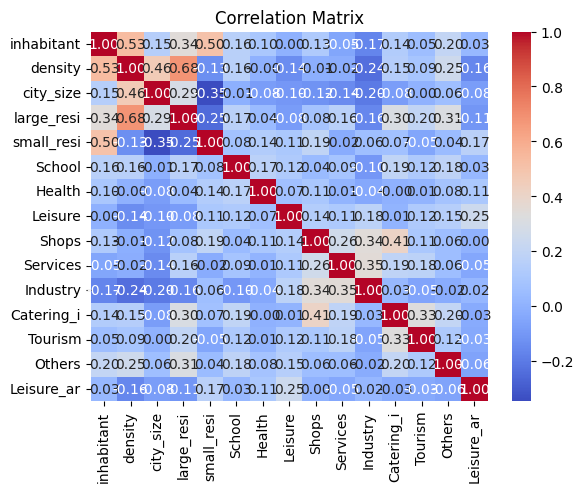

In [17]:
# Check correlation matrix
correlation_matrix = X_train.corr()

# Visualize the correlation matrix
plt.figure()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [18]:
#check for pairs with a high correlation
corr_treshold = 0.5 #set correlation treshold at 0.5

high_correlation_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > corr_treshold: 
            high_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], str(int(100*abs(correlation_matrix.iloc[i, j])))+'%'))
            

print(high_correlation_pairs)
# High correlation between density & large_res --> drop large_res

[('inhabitant', 'density', '53%'), ('inhabitant', 'small_resi', '50%'), ('density', 'large_resi', '68%')]


The correlation matrix shows 3 pairs with a correlation higher than 50%. All the features involved are related to 'population quantities'. It's logical that an area with a lot of large residential buildings will have a high population density. An analogue reasoning can be applied to the other pairs.
To finally decide which features to drop, the mutual info between the features and the target variable is calculated. The mutual info metric shows the dependency between 2 variables based on an entropy estimation. This means that a lot of mutual information will lead to a decrease in uncertainty. Based on this metric it's decided that large_resi will be dropped. This way the largest correlation pair is eliminated. Inhabitant and Density are not dropped as these have a high mutual informatin value and will probably have a big explanatory value in our model. Lastly city_size is also dropped as it has a mutual information value of 0. This means that it is independent compared to the target variable.

In [19]:
from sklearn.feature_selection import mutual_info_regression

# Calculate the mutual info between the target variable 
mutual_info = mutual_info_regression(X_train, y_train)

# Display mutual information scores for each feature
for i, col in enumerate(X_train):  # Exclude the target variable
    print(f"Mutual Information with '{col}': {mutual_info[i]}")

Mutual Information with 'inhabitant': 0.5112812565697533
Mutual Information with 'density': 0.3699652617663518
Mutual Information with 'city_size': 0.0003070093586430289
Mutual Information with 'large_resi': 0.16731709254569171
Mutual Information with 'small_resi': 0.13153301773423332
Mutual Information with 'School': 0.227821942383438
Mutual Information with 'Health': 0.1599886241356563
Mutual Information with 'Leisure': 0.08641389228080243
Mutual Information with 'Shops': 0.14499396639095607
Mutual Information with 'Services': 0.14965396258457053
Mutual Information with 'Industry': 0.04234602341675986
Mutual Information with 'Catering_i': 0.15745757920841452
Mutual Information with 'Tourism': 0.041168768660491795
Mutual Information with 'Others': 0.13797973615485892
Mutual Information with 'Leisure_ar': 0.05092502608304805


Density and inhabitant have a quite high mutual information with the target variable. Since they are related to each other by the area of the zone, a check is also made on how much mutual information they have for each other. This is around 0.47. This is considered sufficiently low to include them both in the model anyway.

In [20]:

mutual_info = mutual_info_regression(X_train['density'].values.reshape(-1, 1), X_train['inhabitant'].values)
print(mutual_info)

mutual_info = mutual_info_regression(X_train['inhabitant'].values.reshape(-1, 1), X_train['density'].values)
print(mutual_info)

# mutual_info = mutual_info_regression(X_train, X_train['density'].values)
# Display mutual information scores for each feature
# for i, col in enumerate(X_train):  # Exclude the target variable
#    print(f"Mutual Information with '{col}': {mutual_info[i]}")

[0.47282842]
[0.47413399]


In [21]:
# Drop large_res based on correlation and lower mutual information. Don't drop inhabitant as it has high mutual information.
X_train = X_train.drop(columns=['large_resi', 'city_size'])
X_val = X_val.drop(columns=['large_resi', 'city_size'])
X_test = X_test.drop(columns=['large_resi', 'city_size'])

## Log transfromation

As seen on the histogram below the POI data is very imbalanced and always right-skewed. To improve the data quality a log transformation will be applied. This transformation is used because the POI data is always non-negative and it leads to a more normal distribution for the features. Most of the zones have either 0 or a very low value for a POI feature. The log transformation will try to balance the data and get to a normal distribution for the number of POI's throughout the zones. To avoid log(0) a constant is added. 
Later on, the predictions will be backtransformed to make sure they are interpretable.

array([[<AxesSubplot: title={'center': 'inhabitant'}>,
        <AxesSubplot: title={'center': 'density'}>,
        <AxesSubplot: title={'center': 'small_resi'}>,
        <AxesSubplot: title={'center': 'School'}>],
       [<AxesSubplot: title={'center': 'Health'}>,
        <AxesSubplot: title={'center': 'Leisure'}>,
        <AxesSubplot: title={'center': 'Shops'}>,
        <AxesSubplot: title={'center': 'Services'}>],
       [<AxesSubplot: title={'center': 'Industry'}>,
        <AxesSubplot: title={'center': 'Catering_i'}>,
        <AxesSubplot: title={'center': 'Tourism'}>,
        <AxesSubplot: title={'center': 'Others'}>],
       [<AxesSubplot: title={'center': 'Leisure_ar'}>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

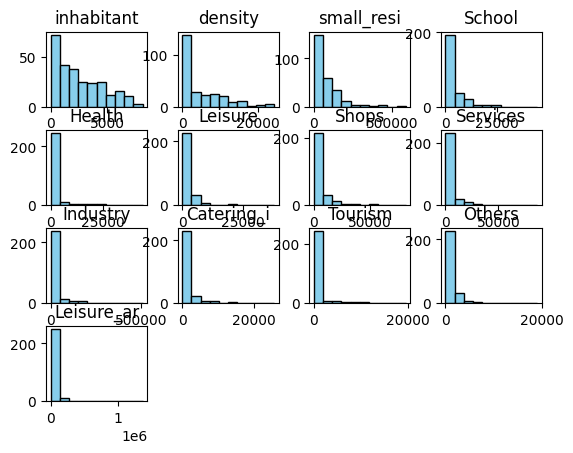

In [22]:
# Show the distribution of the untransformed variables
X_train.hist(color='skyblue', edgecolor='black', grid=False)

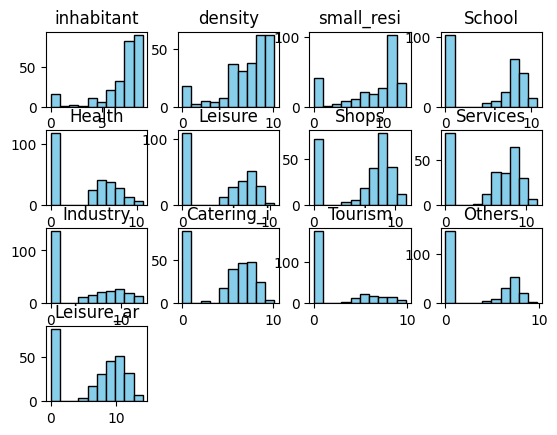

In [23]:
## apply log transformation
if setup_params['logtrans'] == 1:
    X_train = X_train.apply(lambda x: np.log(x + 1))  # Adding 1 to avoid log(0)
    X_val = X_val.apply(lambda x: np.log(x + 1))  
    X_test = X_test.apply(lambda x: np.log(x + 1))  
    X_train.hist(color='skyblue', edgecolor='black', grid=False) # Show the distribution of the Logtransformed variables
    
    y_train = y_train.apply(lambda x: np.log(x + 1))  # Adding 1 to avoid log(0)
    y_val = y_val.apply(lambda x: np.log(x + 1)) 

else:
    print("no log transfromation has been done")

## Outlier detection

The following paragraph creates boxplots for the numerical features. It shows that for the POI features no outliers are found. Inhabitant and density have outliers. This is a consequence of the log transformation. Because of the strong transformation the right skewed data became left skewed. However these outliers won't be taken out for two reasons: Firstly, our dataset is very limited. Secondly, both features were added later on and are perfectly valid instances. It can be interesting to see how the model handles these instances. 

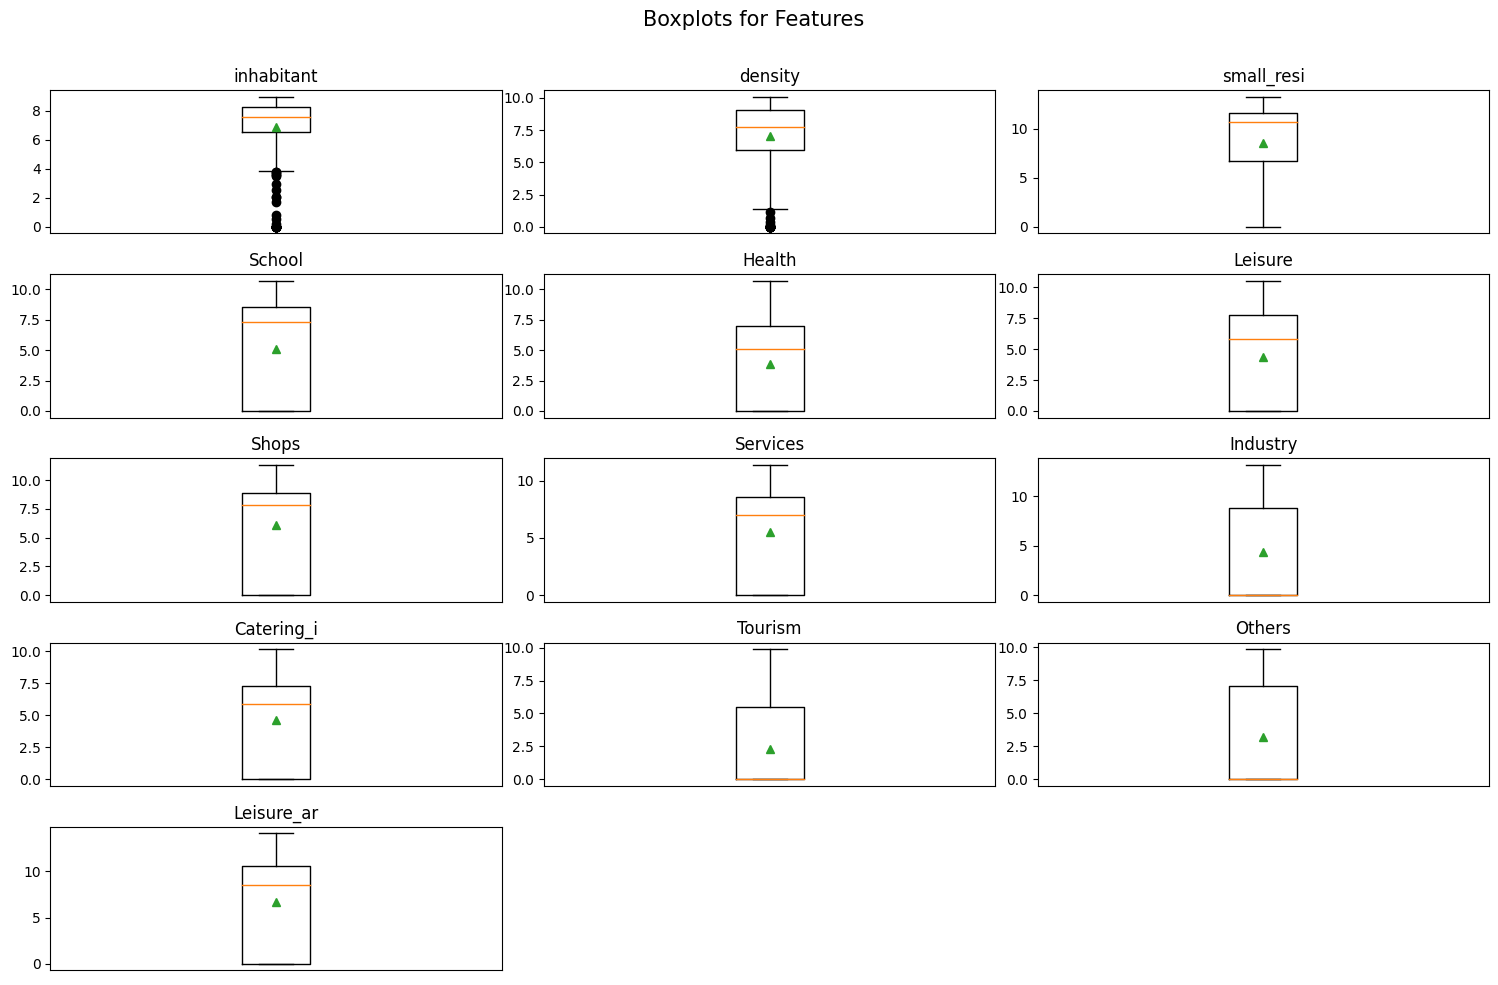

In [24]:
num_features = len(X_train.columns)
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols
flierprops = dict(marker='o', markerfacecolor='black')

# create the figures
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
fig.suptitle("Boxplots for Features", fontsize=15)

# flatten the axes array to easily iterate through the subplots
axes = axes.flatten()

for i, feature in enumerate(X_train.columns):
    ax = axes[i]
    ax.boxplot(X_train[feature], showmeans=True, flierprops=flierprops)
    ax.set_title(feature)
    ax.get_xaxis().set_visible(False)

# hide subplots not being used
for i in range(len(X_train.columns), num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

## Metrics overview function

Here two functions are defined to evaluate the models that are created later. The following metrics are used: true mean, pred_mean, bias, MAE, MSE, RMSE, MAPE, uncentered R^2.
The MAPE gives very high values because of small true values or when the absolute value of the difference between the true and the predicted value is large.


In [25]:
def uncentered_r2_score(true, pred):
    SS_res = np.sum((true - pred) ** 2)
    SS_tot = np.sum((true - np.mean(true)) ** 2)
    return 1 - (SS_res / SS_tot)

In [26]:
def metrics_overview(true_value, predicted_value, printing = True):
    
    metrics_all = []

    added_df = pd.DataFrame()
    added_df['predicted'] = list(predicted_value)
    added_df['value'] = list(true_value)
    
    total = added_df['value'].sum()

    intervals = [(0,250),(250,500),(500,750), (750,1000), (1000,1250),(1250,1500), (1500,1750), (1750, 3000),(3000,4500), (0,4500)]

    for interval_start, interval_end in intervals:
        interval = (interval_start, interval_end)
        interval_df = added_df[(added_df['value'] >= interval_start) & (added_df['value'] < interval_end)]

        if not interval_df.empty:
            true = interval_df['value']
            pred = interval_df['predicted']
            
            nr_zones = true.shape[0] 
            percentage_of_total = true.sum()/total
            true_mean = np.mean(true)
            pred_mean = np.mean(pred)
            bias = pred_mean - true_mean
            MAE = metrics.mean_absolute_error(true, pred)
            MSE = metrics.mean_squared_error(true, pred)
            RMSE = np.sqrt(metrics.mean_squared_error(true, pred))
            MAPE = metrics.mean_absolute_percentage_error(true, pred) #can be very high because of small true or when abs(true -  pred) is large
            uncentered_r2 = uncentered_r2_score(true, pred) #metrics.r2_score(true, pred)
        
        else:   #empty inteval_df
            nr_zones = 0
            percentage_of_total = 0
            true_mean = 0
            pred_mean = 0
            bias = 0
            MAE = 0
            MSE = 0
            RMSE = 0
            MAPE = 0
            uncentered_r2 = 0


        if setup_params['target'] == 'attraction':
            percentage_total_name = 'percentage of total attraction: '
        elif setup_params['target'] == 'production':
            percentage_total_name = 'percentage of total production: '
    
        if printing:
            print('interval: ', interval, ' number of zones: ', nr_zones, percentage_total_name, percentage_of_total)
            print('True mean: ', true_mean, 'Predicted Mean: ', pred_mean, 'Bias: ',bias)
            print('Mean Absolute Error:', MAE)
            print('Mean Squared Error:', MSE)
            print('Root Mean Squared Error:', RMSE)
            print('Mean absolute Percentage Error:' , MAPE)
            print('R2 score: ', uncentered_r2)

        
        
        metrics_all.append({'interval' : interval, 'nr of zones': nr_zones, percentage_total_name : percentage_of_total, 
                        'true mean': true_mean, 'pred mean': pred_mean, 'bias': bias, 'MAE' : MAE, 'MSE': MSE, 'RMSE':RMSE , 'MAPE' : MAPE, 'R2' : uncentered_r2} )

    df_metrics = pd.DataFrame(metrics_all)

    return df_metrics
        

## Function write metrics results to excel

Below is the function that will write the results of the metrics to an excel file.

In [27]:
def write_metrics_overviews_to_excel(name_excel_file, sheet_name, dfs, titles):
    
    # Create an ExcelWriter object
    with pd.ExcelWriter(name_excel_file, engine='xlsxwriter') as writer:

        # Add a worksheet
        writer.book.add_worksheet(sheet_name)

        row = 0
        for df, title in zip(dfs, titles):
            # Write the title
            writer.sheets[sheet_name].write(row, 0, title)
            row += 1
            
            # Write a white line (empty row)
            row += 1
            
            # Write the DataFrame
            df.to_excel(writer, sheet_name=sheet_name, startrow=row, index=False)
            row += len(df) + 2  # Move row pointer to the next position for the next df


# Model

Now the model can be constructed. The model will be made with the XGboost package. This package is the most efficient one for tabular data. XGboost uses an extreme gradient boosting framework. 
<br>
Firstly a regressor model is initialized. Then the hyperparameters are tuned through a 5-fold cross validation. These can also be tuned to avoid overfitting. The model is trained on the preprocessed training data.

## Model

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Parameters: {'colsample_bytree': 0.4, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 40, 'subsample': 0.7}
Best Score (MSE): 0.494379273366558
Test MSE: 0.8579539554061476


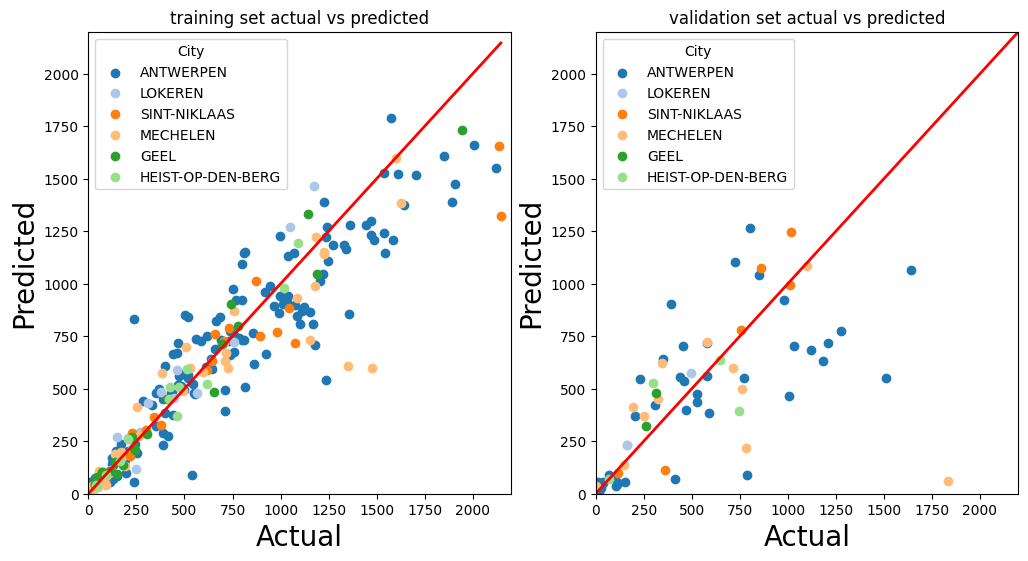

In [28]:
## Training and Validation

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse') #training loss is based on the squared error of the loss, the evaluation metric of the validation set is rmse

#CROSS VALIDATION
if setup_params['CV'] == 0:
    model = xgb.XGBRegressor(colsample_bytree= 0.4, learning_rate= 0.1, max_depth=4, min_child_weight=6, n_estimators= 40, subsample= 0.7) 
    model.fit(X_train, y_train)

elif setup_params['CV'] == 1:
    param_grid = {
        'max_depth': [2, 3, 4],
        'learning_rate': [0.05, 0.1, 0.2],
        'n_estimators': [30, 40, 50],
        'min_child_weight': [4, 5, 6],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.4, 0.5, 0.6],
        # 'reg_alpha': [0.05, 0.075, 0.1], regularization doesnt seem to help
        # 'reg_lambda' : [0.05, 0.075, 0.1]
    }

    # Initialize GridSearchCV with the defined parameter grid and XGBoost model, the scoring function wants to maximize so negative MSE is chosen
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

    # Perform GridSearchCV
    grid_search.fit(X_train, y_train)

    # Get the best parameters and the best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best Parameters:", best_params)
    print("Best Score (MSE):", -best_score)

    # Evaluate the model on the validation data
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_val)
    mse = metrics.mean_squared_error(y_val, y_pred)
    print("Test MSE:", mse)


best_xgb_model = xgb.XGBRegressor(**best_params) #Initialize the model with the best parameters found through cross validation
best_xgb_model.fit(X_train, y_train) #Train the model
model = best_xgb_model

model.save_model(name_model)


# get predictions on training set
y_pred_train = pd.DataFrame(model.predict(X_train))

# get predictions on validation set
y_pred_val = pd.DataFrame(model.predict(X_val))

# Backtransform
if setup_params['logtrans'] == 1:
    X_train = X_train.apply(lambda x: np.exp(x)-1)  # Adding 1 to avoid log(0)
    X_val = X_val.apply(lambda x: np.exp(x)-1)  # Adding 1 to avoid log(0)

    y_train = y_train.apply(lambda x: np.exp(x)-1)  # Adding 1 to avoid log(0)
    y_val = y_val.apply(lambda x: np.exp(x)-1)  # Adding 1 to avoid log(0)

    y_pred_train = y_pred_train.apply(lambda x: np.exp(x)-1)
    y_pred_val = y_pred_val.apply(lambda x: np.exp(x)-1)
else:
    print("no log transfromation has been done")


# Training plot
cities = X_train_with_all_columns['city'].unique()
city_to_color = {city: plt.cm.tab20(i) for i, city in enumerate(cities)}  # Using tab20 colormap for distinct colors

plt.figure(figsize=(12, 6))

# Scatter plot with colors based on city
plt.subplot(1, 2, 1)
for city in cities:
    mask = X_train_with_all_columns['city'] == city
    y_train_city = y_train[mask.to_numpy()]
    y_pred_train_city = y_pred_train[mask.to_numpy()]
    plt.scatter(y_train_city, y_pred_train_city, label=city, color=city_to_color[city])

plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color="r", linestyle="-", linewidth=2)
plt.title("training set actual vs predicted")
plt.ylabel("Predicted", size=20)
plt.xlabel("Actual", size=20)
plt.xlim(0, 2200)  # Set x-axis limit
plt.ylim(0, 2200)  # Set y-axis limit
plt.legend(title='City', loc='upper left')


# Validation plot
plt.subplot(1, 2, 2)
for city in cities:
    mask = X_val_with_all_columns['city'] == city
    y_val_city = y_val[mask.to_numpy()]
    y_pred_val_city = y_pred_val[mask.to_numpy()]
    plt.scatter(y_val_city, y_pred_val_city, label=city, color=city_to_color[city])

plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color="r", linestyle="-", linewidth=2)
plt.title("validation set actual vs predicted")
plt.ylabel("Predicted", size=20)
plt.xlabel("Actual", size=20)
plt.xlim(0, 2200)  # Set x-axis limit
plt.ylim(0, 2200)  # Set y-axis limit
plt.legend(title='City', loc='upper left')

plt.show()

The graphs above show the predictions of the training set and the validation set.  These graphs show a decent fit until the true values are higher than 1500, then the model continuously underestimates the number of trips. No city seems to be remarkably different.


In the graph below the axis are limited to 500. This allows to check the predictions for zones with a low number of trips. Here it shows that a siginificant amount of predicted values are around 50. These are instances with almost no POI's and no inhabitants. 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


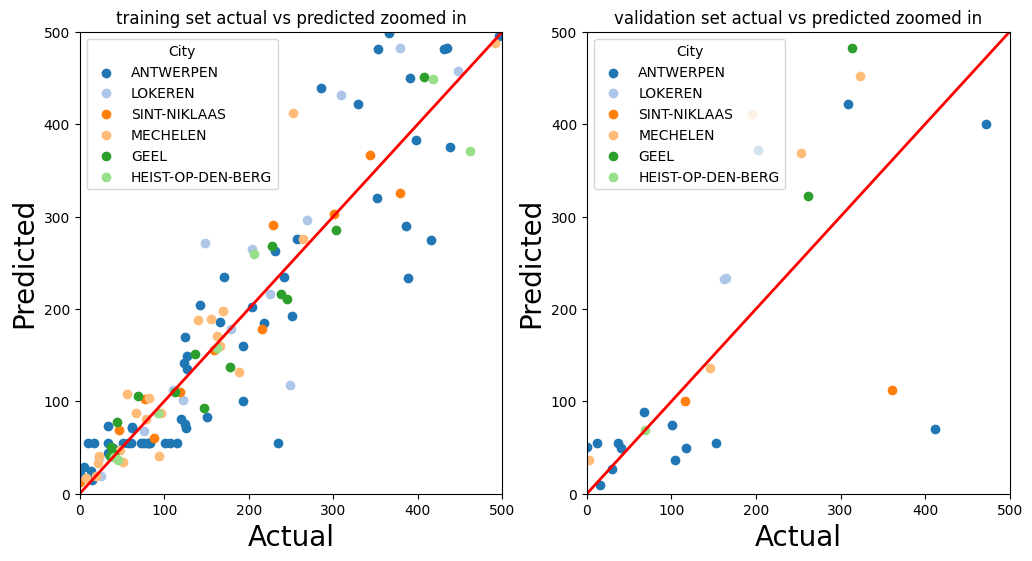

In [29]:
# Scatter plots with colors based on city
plt.figure(figsize=(12, 6))


#training plot

cities = X_train_with_all_columns['city'].unique()
city_to_color = {city: plt.cm.tab20(i) for i, city in enumerate(cities)}  # Using tab20 colormap for distinct colors

plt.subplot(1, 2, 1)
y_train_cities = []        # Store the results per city so that they can be used later
y_pred_train_cities = []   # Store the results per city so that they can be used later
cities_train = cities.copy()    # Store the cities so that the order is known

for city in cities:
    mask = X_train_with_all_columns['city'] == city
    y_train_city = y_train[mask.to_numpy()]
    y_pred_train_city = y_pred_train[mask.to_numpy()]
    y_train_cities.append(y_train_city)
    y_pred_train_cities.append(y_pred_train_city)
    plt.scatter(y_train_city, y_pred_train_city, label=city, color=city_to_color[city])

plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color="r", linestyle="-", linewidth=2)
plt.title("training set actual vs predicted zoomed in")
plt.ylabel("Predicted", size=20)
plt.xlabel("Actual", size=20)
plt.xlim(0, 500)  # Set x-axis limit
plt.ylim(0, 500)  # Set y-axis limit
plt.legend(title='City', loc='upper left')


#validation plot
plt.subplot(1, 2, 2)
y_val_cities = []
y_pred_val_city = []
cities_val = cities.copy()

for city in cities:
    mask = X_val_with_all_columns['city'] == city
    y_val_city = y_val[mask.to_numpy()]
    y_pred_val_city = y_pred_val[mask.to_numpy()]
    y_val_cities.append(y_val_city)
    y_pred_val_city.append(y_pred_val_city )
    plt.scatter(y_val_city, y_pred_val_city, label=city, color=city_to_color[city])

plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color="r", linestyle="-", linewidth=2)
plt.title("validation set actual vs predicted zoomed in")
plt.ylabel("Predicted", size=20)
plt.xlabel("Actual", size=20)
plt.xlim(0, 500)  # Set x-axis limit
plt.ylim(0, 500)  # Set y-axis limit
plt.legend(title='City', loc='upper left')

plt.show()

## Metrics overview TRAIN

In [30]:
# The metrics for all the observations in the training data are calculated
df_metrics_overview_train = metrics_overview(y_train,y_pred_train[0], False)  # If you want to see the output here, change False to True

In [31]:
# Metrics overview per city
dfs_metrics_overview_train_cities = [df_metrics_overview_train]  # Is used to store all the information of the metrics of the training data

# The metrics per city in the training data are calculated
for city, y_train_city, y_pred_train_city in zip(cities_train, y_train_cities, y_pred_train_cities):
    df_metrics_overview_train_city = metrics_overview(y_train_city, y_pred_train_city[0], False)   # If you want to see the output here, change False to True
    dfs_metrics_overview_train_cities.append(df_metrics_overview_train_city)

divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide


In [32]:
# Write the results of the metrics to excel
name_tables = ['ALL TOGHETER'] + list(cities_train)
name_excel_file = name_excel_file_metrics + '_TRAIN.xlsx'
write_metrics_overviews_to_excel(name_excel_file, 'TRAIN', dfs_metrics_overview_train_cities, name_tables)

## Model on test data

The following part will use the trained model to predict the number of trips in the test set. The graphs below show similar behaviour as in the training set. Here, the overestimation for very low values is more evident, as well as the underestimation by the values above 1500.

attraction


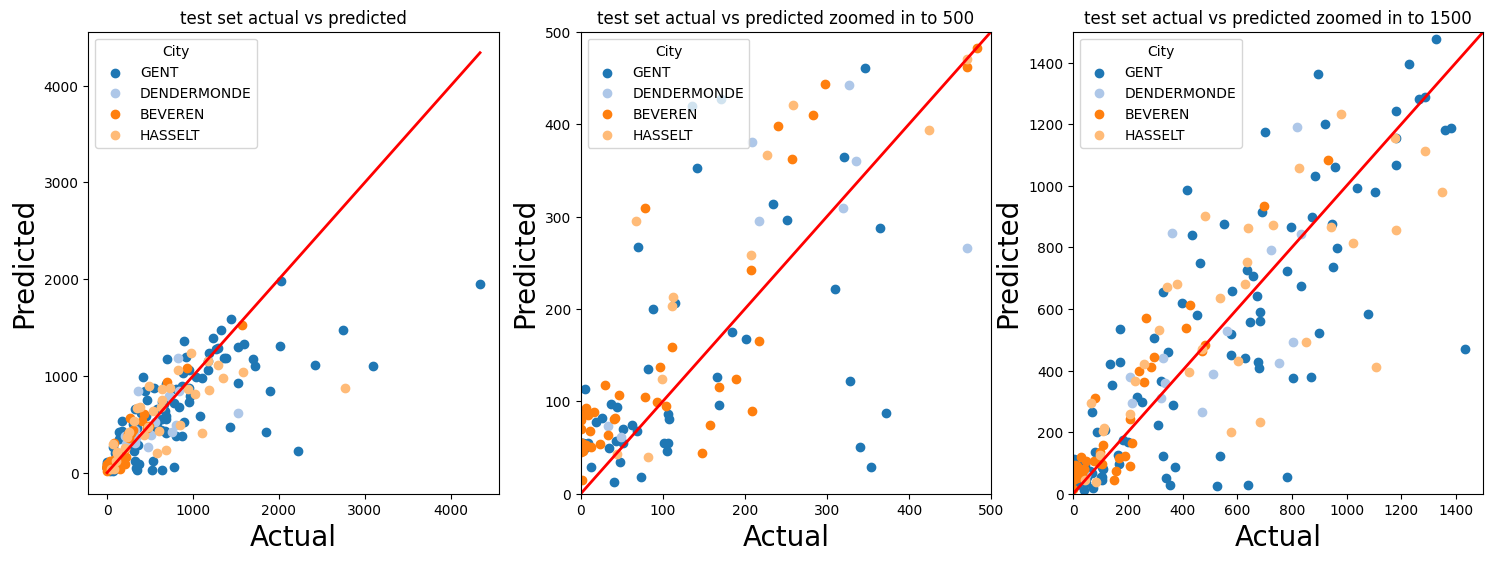

In [33]:
print(setup_params['target'])

model = xgb.XGBRegressor()
model.load_model(name_model) #If you have the trained model saved as a .json file, you can immediatly load it in here and make predictions on the test set. 

# get predictions on validation set
y_pred_test = pd.DataFrame(model.predict(X_test))

#Backtransform
if setup_params['logtrans'] == 1:
    X_test = X_test.apply(lambda x: np.exp(x)-1)  # Adding 1 to avoid log(0)
    y_pred_test = y_pred_test.apply(lambda x: np.exp(x)-1)
else:
    print("no log transfromation has been done")
    

#test plot
cities = X_test_with_all_columns['city'].unique()
city_to_color = {city: plt.cm.tab20(i) for i, city in enumerate(cities)}  # Using tab20 colormap for distinct colors
plt.figure(figsize = (18,6))
plt.subplot(1, 3, 1)
y_test_cities = []              # Store the results per city so that they can be used later
y_pred_test_cities = []         # Store the results per city so that they can be used later
cities_test = cities.copy()     # Store the cities so that the order is known


for city in cities:
    mask = X_test_with_all_columns['city'] == city
    y_test_city = y_test[mask.to_numpy()]
    y_pred_test_city = y_pred_test[mask.to_numpy()]
    y_test_cities.append(y_test_city)
    y_pred_test_cities.append(y_pred_test_city)
    plt.scatter(y_test_city, y_pred_test_city, label=city, color=city_to_color[city])

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="r", linestyle="-", linewidth=2)
plt.title("test set actual vs predicted")
plt.ylabel("Predicted", size=20)
plt.xlabel("Actual", size=20)
plt.legend(title='City', loc='upper left')

plt.subplot(1, 3, 2)
for city in cities:
    mask = X_test_with_all_columns['city'] == city
    y_test_city = y_test[mask.to_numpy()]
    y_pred_test_city = y_pred_test[mask.to_numpy()]
    plt.scatter(y_test_city, y_pred_test_city, label=city, color=city_to_color[city])

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="r", linestyle="-", linewidth=2)
plt.title("test set actual vs predicted zoomed in to 500")
plt.ylabel("Predicted", size=20)
plt.xlabel("Actual", size=20)
plt.xlim(0, 500)  # Set x-axis limit
plt.ylim(0, 500)  # Set y-axis limit
plt.legend(title='City', loc='upper left')

plt.subplot(1, 3, 3)
for city in cities:
    mask = X_test_with_all_columns['city'] == city
    y_test_city = y_test[mask.to_numpy()]
    y_pred_test_city = y_pred_test[mask.to_numpy()]
    plt.scatter(y_test_city, y_pred_test_city, label=city, color=city_to_color[city])

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="r", linestyle="-", linewidth=2)
plt.title("test set actual vs predicted zoomed in to 1500")
plt.ylabel("Predicted", size=20)
plt.xlabel("Actual", size=20)
plt.xlim(0, 1500)  # Set x-axis limit
plt.ylim(0, 1500)  # Set y-axis limit
plt.legend(title='City', loc='upper left')

plt.show()

## Metrics overview TEST

In [34]:
# The metrics for all the observations in the test data are calculated
df_metrics_test = metrics_overview(y_test,y_pred_test[0], False)    # If you want to see the output here, change False to True

In [35]:
# Metrics overview per city

dfs_metrics_overview_test_cities = [df_metrics_test] # Is used to store all the information of the metrics of the training data

# The metrics per city in the training data are calculated
for city, y_test_city, y_pred_test_city in zip(cities_test, y_test_cities, y_pred_test_cities):
    df_metrics_overview_test_city = metrics_overview(y_test_city, y_pred_test_city[0], False)   # If you want to see the output here, change False to True
    dfs_metrics_overview_test_cities.append(df_metrics_overview_test_city)

divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide


In [36]:
# Write the results to excel
name_tables = ['ALL TOGHETER'] + list(cities_test)
name_excel_file = name_excel_file_metrics + '_TEST.xlsx'
write_metrics_overviews_to_excel(name_excel_file, 'TEST', dfs_metrics_overview_test_cities, name_tables)

# Interpretation of the results

## SHAP

The interpretation starts with an analysis of the shapley values. The shapley values of the test set will be used. However the code can also handle the training set.

In [37]:
# Specify which model and which datasets of points you want to analyse with the SHAP values
X_shap = X_test  # X_val, ...

explainer = shap.Explainer(model)
shap_values = explainer(X_shap)

print(setup_params['target'])
print(explainer.expected_value)

attraction
5.817875


### Summary plot

In a summary plot, features are ranked according to their average absolute SHAP value. This indicates how much each feature contributes to a prediction.

So Inhabitant is the most import feature for the attraction model. Then there are a whole host of features that have a significantly lower impact. It's interesting to see that school, services and shops have a significant importance in the prediction. It's also logical for an attraction model in morning rush hour as these POI's are likely to play a big role in attraction at that time. 

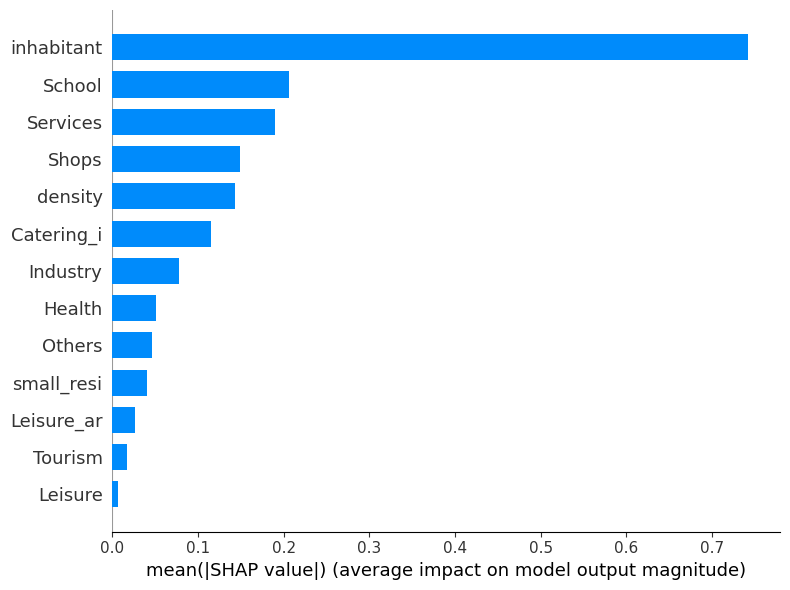

In [38]:
shap.summary_plot(shap_values, X_shap, plot_type="bar", plot_size=[8,6])

### Beeswarm plot

In contrast to the mean value in the summary plot, the beeswarm plots the values of the shap values of each observation for each feature. Moreover, the colour indicates the value for that particular feature for the observation.

For the features from inhabitant to others, the beeswarm plot indicates that a high SHAP value always corresponds to a high value for that feature. This follows the intuition that a high value for any of these features leads to an increased attraction. For Tourism and Leisure, no clear outcome is visible. Note that small_resi is the only feature that has negative shap values at a high value for the feature. This is remarkable. This means that in the morning rush hour zones with a lot of small_resi, the shap value will have a negative impact.

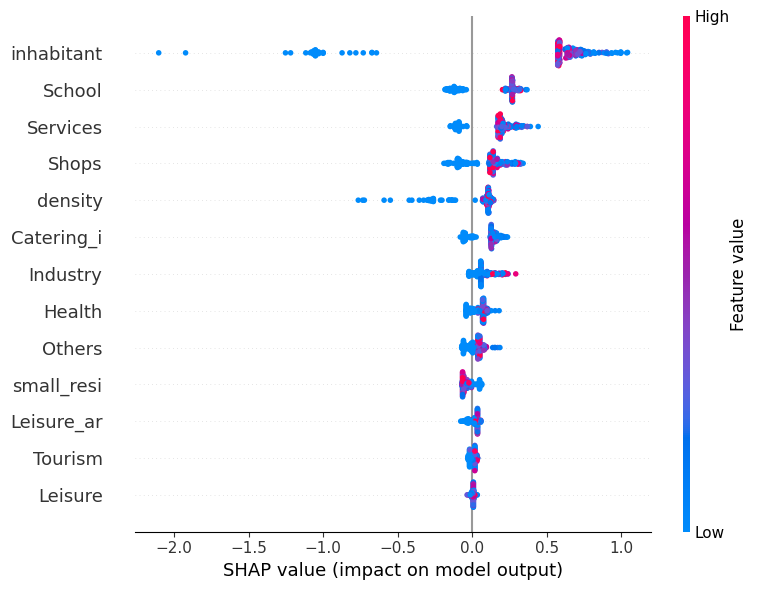

In [39]:
shap.summary_plot(shap_values, X_shap, plot_size=[8,6])

## Calculation absolute difference and percentage error per zone

In the following part the absolute difference and the percentage error between the real and the predicted values is calculated. Based on these values plots are made. Later these values will be used to analyse the over- and  underestimation. 

In [40]:
interest = 'test'  # 'train' is cities of the train data set, 'test' is the cities of the test dataset (has to be the same as X_shap)
print(interest)

if interest == 'train':
    # zones_plot = zones_city[zones_city["NIS_GEM_L"].str.contains("ANTWERPEN")]
    data_plot = pd.concat([X_train_with_all_columns, X_val_with_all_columns], ignore_index=True)  # Add X_train & X_val togheter and use this files so that the order is the same as in the real_values list

    pred_values_list_train = y_pred_train[0].values.flatten().tolist()
    pred_values_list_val = y_pred_val[0].values.flatten().tolist()
    pred_values_list = pred_values_list_train + pred_values_list_val
    real_values_list_train = y_train.tolist()
    real_values_list_val = y_val.tolist()
    real_values_list = real_values_list_train + real_values_list_val

elif interest == 'test':
    # zones_plot = zones_city[zones_city["NIS_GEM_L"].str.contains("GENT")]
    data_plot = data_test.copy()

    pred_values_list = y_pred_test.values.flatten().tolist()
    real_values_list = list(y_test)  

test


In [41]:
# Make the list with the difference between the predicted value and the 'real' value
result_difference = [x - y for x, y in zip(pred_values_list, real_values_list)]
percentage_error = [((x - y)/(y+1))*100 for x, y in zip(pred_values_list, real_values_list)]    # +1 so that there is no division by zero

### Plots

These plots are made per city:
- Attraction: values from attraction from the MOW, so not the model
- Absolute difference: absolute difference of outcome model vs values from MOW data
- Percentage difference: percentage difference of outcome model vs values from MOW data
- Filtered percentage difference: only the percentage difference that have an absolute difference bigger than the printed threshold


The colour bar of the absolute and percentage differences are fixed between [-100; 100] and [-500; 500], respectively. If the number of a zone is higher than the interval, the zone is coloured black and if it is lower than the interval, it is coloured yellow. A symmetrical interval is imposed so that the colours follow the intuition of white is neutral, red is negative and blue is positive. Working with fixed values for all cities ensures that cities can be easily compared with each other as this way the same colour means the same difference in each city. In addition, a very important reason for imposing these intervals is that if this is not done, little difference in colour can be observed. This is because in most cities there are a few extreme outliers. 

Cities are from:  test
Threshold for absolute value by filtering:  100
GENT


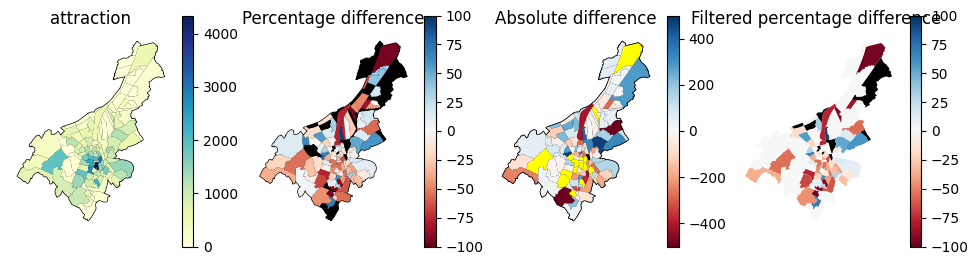

DENDERMONDE


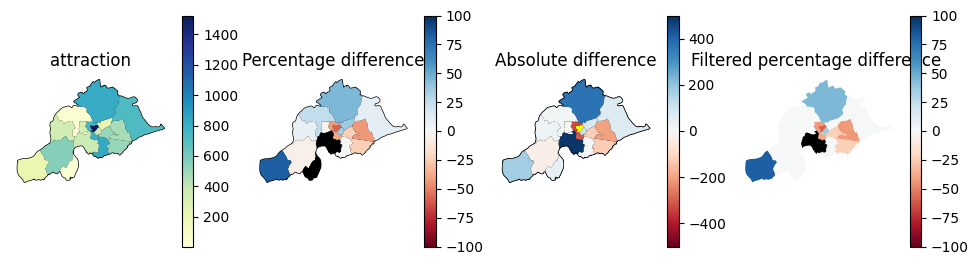

BEVEREN


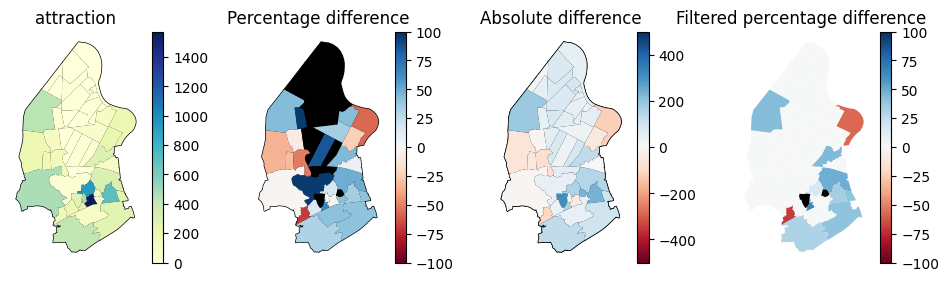

HASSELT


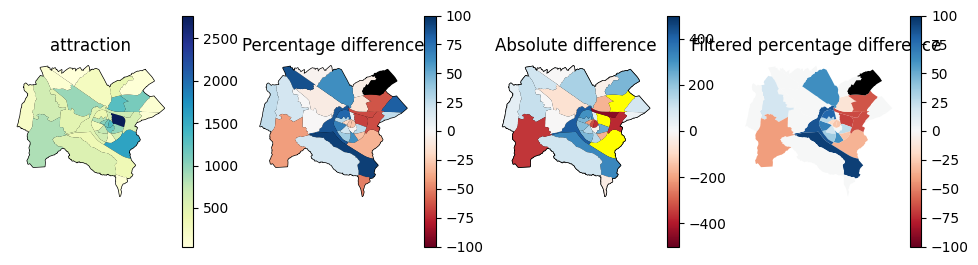

In [42]:
print('Cities are from: ', interest) 

threshold_filtering_absolute_value = 100  # Threshold 

print('Threshold for absolute value by filtering: ',threshold_filtering_absolute_value)

cities = data_plot['city'].unique()

cmap_adapted = plt.cm.get_cmap('RdBu')
cmap_adapted.set_over('black')  # Values above vmax (see later in subplot) will be plotted in black
cmap_adapted.set_under('yellow')  # Values below vmin (see later in subplot) will be plotted in yellow


# Iterate over each city and plot
for city in cities:
    print(city)
    city_data = data_plot[data_plot['city'] == city]

    # Extract the indices for the current city data
    indices = city_data.index

    # Create a filtering for the percentages with a min difference of absolute values
    adapted_percentages = []
    for i in indices:
        if abs(result_difference[i]) > threshold_filtering_absolute_value:
            adapted_percentages.append(percentage_error[i]) 
        else:
            adapted_percentages.append(0)  # So that this does not get a colour if the absolute difference is lower than the threshold

    fig, axes = plt.subplots(1, 4, figsize=(12, 3))

    # Plot the GeoPandas DataFrame for the current city in all subplots
    city_data.plot(ax=axes[0], color='lightgray', edgecolor='black')
    city_data.plot(ax=axes[1], color='lightgray', edgecolor='black')
    city_data.plot(ax=axes[2], color='lightgray', edgecolor='black')
    city_data.plot(ax=axes[2], color='lightgray', edgecolor='black')

    # Plot the values for attraction
    city_data.assign(values=data_plot[setup_params['target']]).plot(
        column='values', cmap='YlGnBu', linewidth=0, legend=True, ax=axes[0])
    axes[0].set_title(setup_params['target'])
    axes[0].set_axis_off()  # Remove the axes because these are the coordinates and does not provide added value

    # Plot the percentage difference 
    city_data.assign(values=[percentage_error[i] for i in indices]).plot(
        column='values', cmap= cmap_adapted, linewidth=0, legend=True, ax=axes[1], vmin = - 100, vmax = 100)
    axes[1].set_title(f'Percentage difference')
    axes[1].set_axis_off()  # Remove the axes because these are the coordinates and does not provide added value
    
    # Plot the absolute difference
    city_data.assign(values=[result_difference[i] for i in indices]).plot(
        column='values', cmap=cmap_adapted, linewidth=0, legend=True, ax=axes[2], vmin = - 500, vmax = 500)
    axes[2].set_title(f'Absolute difference')
    axes[2].set_axis_off()  # Remove the axes because these are the coordinates and does not provide added value

    # Plot the percentage difference where the condition is met
    city_data.assign(values=adapted_percentages).plot(
        column='values', cmap= cmap_adapted, linewidth=0, legend=True, ax=axes[3], vmin = - 100, vmax = 100)
    axes[3].set_title(f'Filtered percentage difference ')
    axes[3].set_axis_off()  # Remove the axes because these are the coordinates and does not provide added value
    

    # Show the plot
    plt.show()

The City of Beveren shows why a filtered percentage difference plot is also made. As can be seen, in the unfiltered plot, a large proportion of the zones are coloured black (i.e. more than 100% difference). Most of these black zones have a low attraction value (port area), resulting in such large percentages. As a result, most of the zones have been filtered out because the absolute difference does not exceed 100, and as a result, in the filtered percentage difference plot, there are not many black zones left.

In the plots above, no clear patterns can be observed for systematic under- or overestimation in or outside the city core. 

## Underestimation

The following part checks why some of the instances are underestimated. A zone is greatly underestimated when the percentage error is lower than -75%. In total 9 zones are underestimated. All of these zones are from Gent. 
<br>
The underestimated cases can be divided in 2 cases. In the first case the underestimation is caused because of the 'inhabitant' feature. For example in zone 2500, 2505, 2507 and 2550 this feature is very low. In the second case all POI featuress are 0 and the features like density and inhabitant are close to 0, for all these instances the model predicts about 50 attracted trips. This is completely wrong as the model doesn't have enough information. 

The zones '2500', '2505' and '2507' are situated just outside the city center in the South, while the others are situated in the port. 

33     GENT
38     GENT
40     GENT
53     GENT
58     GENT
64     GENT
83     GENT
109    GENT
110    GENT
Name: city, dtype: object


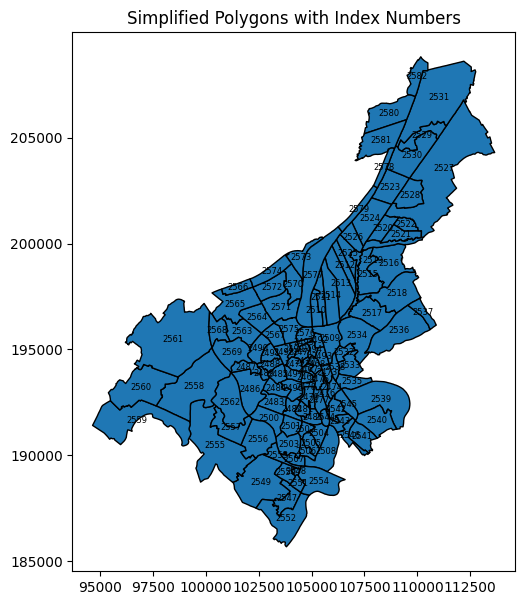

In [56]:
zone_numbers_underestimation = ['2500', '2505', '2507', '2520', '2525', '2531', '2550', '2576', '2577']  # These zonenumbers are determined in the next chunck of code
print(data_test[data_test['ZONENUMMER'].isin(zone_numbers_underestimation)]['city'])

# Define the size of the plot
fig, ax = plt.subplots(figsize=(7, 7))  

# Plot the polygons
data_test_GENT = data_test[data_test['city'] == 'GENT']
data_test_GENT.plot(edgecolor='black', linewidth=1, ax=ax)

# Add index numbers for each polygon
for idx, row in data_test_GENT.iterrows():
    centroid = row.geometry.centroid
    zone_number = row['ZONENUMMER']
    ax.text(centroid.x, centroid.y, str(zone_number), fontsize=6, ha='center', va='center')  # index is used instead of idx

# Set labels and title
ax.set_title('Simplified Polygons with Index Numbers')

# Show the plot
plt.show()

In [44]:
#Underestimation 
indices = [index for index, value in enumerate(percentage_error) if (value <= -75)]
print(interest)
shap.initjs()

for indx in indices:
    zone_nr = data_plot.iloc[indx]['ZONENUMMER']
    print('\nZone number:', zone_nr)
    print("     Predicted value: ", pred_values_list[indx])
    print("     Real value: ", real_values_list[indx])
    print("     percentage error: ", percentage_error[indx])

    if interest == 'test':
        index = data_test.index[data_test['ZONENUMMER'] == zone_nr]
        print(data_test[data_test["ZONENUMMER"] == zone_nr].head())
        display(shap.force_plot(explainer.expected_value, shap_values.values[index,:], X_shap.iloc[index,:]))

    elif interest == 'train':
        index = data_train.index[data_train['ZONENUMMER'] == zone_nr]
        print(data_train[data_train["ZONENUMMER"] == zone_nr])
        display(shap.force_plot(explainer.expected_value, shap_values.values[index,:], X_shap.iloc[index,:]))

        
print("number of hits: ", len(indices))
## ATTRACTION
# zone 2500/2505/2507/2550 : Low inhabitants cause underestimation
# zone 2525/2531: high real value but no POI's and no inhabitants, No POI's actually decrease the prediction, this was not necessary here
# zone 2577: No POI's actually decrease the prediction, this was not necessary here
# Also remarkable that all of these are from Gent and not from the smaller cities

## PRODUCTION
# Almost everything here depends on the nr of inhabitants: if this doenst correspond than the prediction is bad
# interesting relation between density and inhabitants


test



Zone number: 2500
     Predicted value:  424.416259765625
     Real value:  1852.279
     percentage error:  -77.04521230933794
   ZONENUMMER   inhabitant      density  city  city_size  production  \
33       2500  1468.295797  1361.593752  GENT     270000     441.278   

    attraction   large_resi    small_resi        School      Health  \
33    1852.279  3662.667829  68196.121332  45913.552371  507.229676   

        Leisure        Shops     Services   Industry   Catering_i     Tourism  \
33  2724.088602  3041.152598  6071.238743  75.111416  1674.434007  210.995544   

       Others     Leisure_ar  \
33  978.38481  126608.994928   

                                             geometry  
33  POLYGON ((103304.857 190856.198, 103295.317 19...  



Zone number: 2505
     Predicted value:  224.587646484375
     Real value:  2223.5040000000004
     percentage error:  -89.85896871912233
   ZONENUMMER  inhabitant     density  city  city_size  production  \
38       2505  383.442156  794.262376  GENT     270000     131.502   

    attraction  large_resi  small_resi      School        Health     Leisure  \
38    2223.504         0.0  3508.21136  9762.93336  84135.815336  718.986467   

        Shops     Services  Industry  Catering_i  Tourism       Others  \
38  901.77029  1192.356578       0.0   403.61308      0.0  2286.867772   

      Leisure_ar                                           geometry  
38  42630.986278  POLYGON ((104568.578 190789.164, 104596.036 19...  



Zone number: 2507
     Predicted value:  28.882957458496094
     Real value:  353.51400000000007
     percentage error:  -91.57072570942302
   ZONENUMMER  inhabitant     density  city  city_size  production  \
40       2507  261.705325  597.360588  GENT     270000      57.515   

    attraction  large_resi   small_resi        School      Health  \
40     353.514         0.0  9099.298158  21762.926491  506.980609   

        Leisure  Shops     Services    Industry  Catering_i  Tourism  Others  \
40  1738.231023    0.0  1126.932707  2395.97894         0.0      0.0     0.0   

      Leisure_ar                                           geometry  
40  12800.869692  POLYGON ((104463.128 189972.509, 104492.133 18...  



Zone number: 2520
     Predicted value:  51.08506393432617
     Real value:  339.978
     percentage error:  -84.72480220591177
   ZONENUMMER  inhabitant   density  city  city_size  production  attraction  \
53       2520    0.147875  0.174431  GENT     270000      30.976     339.978   

    large_resi  small_resi  School  Health  Leisure  Shops     Services  \
53         0.0         0.0     0.0     0.0      0.0    0.0  1921.396313   

         Industry  Catering_i  Tourism  Others  Leisure_ar  \
53  294888.747891  145.610865      0.0     0.0         0.0   

                                             geometry  
53  POLYGON ((108895.956 200918.701, 108255.699 20...  



Zone number: 2525
     Predicted value:  54.65684509277344
     Real value:  780.999
     percentage error:  -92.88274728065208
   ZONENUMMER  inhabitant  density  city  city_size  production  attraction  \
58       2525         0.0      0.0  GENT     270000        25.0     780.999   

    large_resi  small_resi  School  Health  Leisure  Shops  Services  \
58         0.0         0.0     0.0     0.0      0.0    0.0       0.0   

    Industry  Catering_i  Tourism  Others  Leisure_ar  \
58       0.0         0.0      0.0     0.0         0.0   

                                             geometry  
58  POLYGON ((106355.784 200453.284, 106360.153 20...  



Zone number: 2531
     Predicted value:  23.580129623413086
     Real value:  525.638
     percentage error:  -95.33263273379188
   ZONENUMMER  inhabitant   density  city  city_size  production  attraction  \
64       2531    0.732283  0.104383  GENT     270000      17.638     525.638   

    large_resi  small_resi  School  Health  Leisure  Shops  Services  \
64         0.0         0.0     0.0     0.0      0.0    0.0       0.0   

    Industry  Catering_i  Tourism  Others  Leisure_ar  \
64       0.0         0.0      0.0     0.0         0.0   

                                             geometry  
64  POLYGON ((109072.236 204556.156, 109049.418 20...  



Zone number: 2550
     Predicted value:  27.481016159057617
     Real value:  639.999
     percentage error:  -95.55677681883161
   ZONENUMMER  inhabitant     density  city  city_size  production  \
83       2550  104.233716  180.751702  GENT     270000        22.0   

    attraction  large_resi  small_resi        School  Health  Leisure  \
83     639.999         0.0         0.0  40094.025809     0.0      0.0   

         Shops      Services      Industry  Catering_i  Tourism  Others  \
83  184.372492  18500.234352  21720.013717  116.436537      0.0     0.0   

      Leisure_ar                                           geometry  
83  16155.641099  POLYGON ((103984.221 188637.886, 103893.983 18...  



Zone number: 2576
     Predicted value:  87.29978942871094
     Real value:  371.865
     percentage error:  -76.31856317200302
    ZONENUMMER  inhabitant     density  city  city_size  production  \
109       2576   165.60206  382.196038  GENT     270000      32.868   

     attraction  large_resi   small_resi  School  Health      Leisure  \
109     371.865         0.0  1400.440288     0.0     0.0  6144.445238   

            Shops     Services       Industry  Catering_i      Tourism  \
109  26064.824337  8404.392236  102568.904169  699.919311  6711.788668   

     Others  Leisure_ar                                           geometry  
109     0.0         0.0  POLYGON ((105031.242 196075.187, 105035.238 19...  



Zone number: 2577
     Predicted value:  121.0788803100586
     Real value:  535.822
     percentage error:  -77.25896473876655
    ZONENUMMER   inhabitant     density  city  city_size  production  \
110       2577  1476.662166  463.560735  GENT     270000     321.824   

     attraction  large_resi  small_resi  School  Health  Leisure  Shops  \
110     535.822         0.0  557.398635     0.0     0.0      0.0    0.0   

     Services     Industry  Catering_i  Tourism  Others  Leisure_ar  \
110       0.0  9850.521485         0.0      0.0     0.0         0.0   

                                              geometry  
110  POLYGON ((106450.301 200546.745, 106409.952 20...  


number of hits:  9


## Overestimation

For the very large overestimate, the zones examined are those where at least three times is estimated (200%) and there is a minimum overestimate of an absolute value of 100. The condition for a minimum absolute value of 100 is because for small absolute numbers, a difference is immediately a large percentage difference. 

There are 6 zones with a considered big overestimation, of which there are 4 in Gent, 1 in Beveren and 1 in Hasselt.

In [45]:
zone_numbers_overestimation = ['2470', '2527', '2499', '2537', '2725', '2949']
data_test[data_test['ZONENUMMER'].isin(zone_numbers_overestimation)]['city']

3         GENT
32        GENT
60        GENT
70        GENT
136    BEVEREN
206    HASSELT
Name: city, dtype: object

These overestimated instances all have a similar behaviour. Compared to good predictions they have either more inhabitants or way more POI's of some kind. 
<br>
If the absolute difference can be lower than 100. A different kind of overestimation emerges. The percentage error is high but all the real values are between 0 and 5. So it seems like our model also can't capture those. 
Even when all POIS are 0 or very low the model doesnt go low enough. This can be caused because of the training data has to much different scenarios for very low/no POI zones.


In [46]:
#Plot zones with a similar attraction to overestimated zone 2470
index = data_test[data_test[setup_params['target']] >= 168]
index = index[index[setup_params['target']] <= 172]
index.head()

,ZONENUMMER,inhabitant,density,city,city_size,production,attraction,large_resi,small_resi,School,Health,Leisure,Shops,Services,Industry,Catering_i,Tourism,Others,Leisure_ar,geometry
3,2470,879.090943,8459.200304,GENT,270000,245.520,170.511,7645.839036,35345.222585,0.000000,346.997186,92.178082,1662.331753,1498.794963,0.00000,7764.661214,4133.462087,0.0,1879.121492,"POLYGON ((104839.808 194650.326, 104838.648 19..."
54,2521,0.010497,0.012473,GENT,270000,13.000,168.002,0.000000,0.000000,0.000000,0.000000,0.000000,863.483654,863.483654,178110.46181,0.000000,0.000000,0.0,0.000000,"POLYGON ((108255.699 200043.931, 108895.956 20..."
105,2572,3166.856206,2644.120410,GENT,270000,537.290,171.294,0.000000,123706.074111,2696.696112,674.293549,3866.709077,1195.848003,1238.550186,0.00000,292.172027,0.000000,0.0,264453.916355,"POLYGON ((103638.480 198695.187, 103698.424 19..."
146,2735,67.201559,48.773782,BEVEREN,50000,7.881,168.880,0.000000,5650.733123,0.000000,0.000000,0.000000,0.000000,17562.704234,222749.98862,115.550372,0.000000,0.0,0.000000,"POLYGON ((138289.638 216078.495, 138375.790 21..."


In [47]:
shap.initjs()
zone_nr = '2572'
index = data_test.index[data_test['ZONENUMMER'] == zone_nr]
print(index)
display(shap.force_plot(explainer.expected_value, shap_values.values[index,:], X_shap.iloc[index,:]))
# print(data_test[data_test["ZONENUMMER"] == zone_nr].head())

indx = 105
print('\nZone number:', zone_nr)
print("     Predicted value: ", pred_values_list[indx])
print("     Real value: ", real_values_list[indx])
print("     percentage error: ", percentage_error[indx])

Int64Index([105], dtype='int64')



Zone number: 2572
     Predicted value:  426.94097900390625
     Real value:  171.294
     percentage error:  148.3783410936575


In [48]:
#Plot shapley values and force plots for overestimated instances
indices = [index for index, value in enumerate(percentage_error) if (value >= 200 and result_difference[index] > 100)]

print(interest)
shap.initjs()

for indx in indices:
    zone_nr = data_plot.iloc[indx]['ZONENUMMER']
    print('\nZone number:', zone_nr)
    print("     Predicted value: ", pred_values_list[indx])
    print("     Real value: ", real_values_list[indx])
    print("     percentage error: ", percentage_error[indx])

    if interest == 'test':
        index = data_test.index[data_test['ZONENUMMER'] == zone_nr]
        display(shap.force_plot(explainer.expected_value, shap_values.values[index,:], X_shap.iloc[index,:]))
        print(data_test[data_test["ZONENUMMER"] == zone_nr].head())

    elif interest == 'train':
        index = data_train.index[data_train['ZONENUMMER'] == zone_nr]
        display(shap.force_plot(explainer.expected_value, shap_values.values[index,:], X_shap.iloc[index,:]))
        print(data_train[data_train["ZONENUMMER"] == zone_nr])

        
print("number of hits: ", len(indices))
## PRODUCTION
# percentage error are much lower than attraction
# low production zones are mostly predicted pretty well (high percentage error but very low absolute difference)

test



Zone number: 2470
     Predicted value:  533.6339721679688
     Real value:  170.511
     percentage error:  211.71993176412522


  ZONENUMMER  inhabitant      density  city  city_size  production  \
3       2470  879.090943  8459.200304  GENT     270000      245.52   

   attraction   large_resi    small_resi  School      Health    Leisure  \
3     170.511  7645.839036  35345.222585     0.0  346.997186  92.178082   

         Shops     Services  Industry   Catering_i      Tourism  Others  \
3  1662.331753  1498.794963       0.0  7764.661214  4133.462087     0.0   

    Leisure_ar                                           geometry  
3  1879.121492  POLYGON ((104839.808 194650.326, 104838.648 19...  

Zone number: 2499
     Predicted value:  266.58673095703125
     Real value:  69.815
     percentage error:  277.8673034767087


   ZONENUMMER   inhabitant     density  city  city_size  production  \
32       2499  1065.914662  4435.71459  GENT     270000     157.816   

    attraction    large_resi  small_resi      School      Health     Leisure  \
32      69.815  16828.229874  473.673984  990.957146  984.879414  262.314971   

    Shops      Services     Industry  Catering_i  Tourism       Others  \
32    0.0  17944.870175  1160.786737  228.382715      0.0  1749.390295   

      Leisure_ar                                           geometry  
32  55591.922218  POLYGON ((104434.123 195096.747, 104427.548 19...  

Zone number: 2527
     Predicted value:  419.85076904296875
     Real value:  135.21900000000002
     percentage error:  208.95159195337553


   ZONENUMMER   inhabitant     density  city  city_size  production  \
60       2527  2223.877829  212.224867  GENT     270000     328.219   

    attraction  large_resi    small_resi  School  Health  Leisure  \
60     135.219         0.0  38152.039098     0.0     0.0      0.0   

          Shops     Services      Industry  Catering_i  Tourism       Others  \
60  2092.137582  9596.350482  23732.974075         0.0      0.0  1682.575212   

     Leisure_ar                                           geometry  
60  2245.440834  POLYGON ((108468.841 201372.444, 108515.982 20...  

Zone number: 2537
     Predicted value:  113.10284423828125
     Real value:  4.944999999999999
     percentage error:  1819.3077247818546


   ZONENUMMER  inhabitant    density  city  city_size  production  attraction  \
70       2537   52.020093  84.999214  GENT     270000       5.945       4.945   

    large_resi   small_resi  School  Health  Leisure         Shops  \
70         0.0  3069.658404     0.0     0.0      0.0  10081.131298   

       Services  Industry  Catering_i  Tourism  Others  Leisure_ar  \
70  1463.453674       0.0         0.0      0.0     0.0         0.0   

                                             geometry  
70  MULTIPOLYGON (((109551.529 197089.850, 109575....  

Zone number: 2725
     Predicted value:  309.6233825683594
     Real value:  78.67
     percentage error:  289.8875142065512


    ZONENUMMER  inhabitant      density     city  city_size  production  \
136       2725  498.883892  1057.719353  BEVEREN      50000       70.67   

     attraction   large_resi    small_resi  School  Health  Leisure  \
136       78.67  5587.272108  27617.555429     0.0     0.0      0.0   

            Shops    Services      Industry  Catering_i  Tourism  Others  \
136  18271.627415  750.637821  58808.502906         0.0      0.0     0.0   

      Leisure_ar                                           geometry  
136  4241.733894  POLYGON ((142563.357 212027.747, 142597.260 21...  

Zone number: 2949
     Predicted value:  294.6937561035156
     Real value:  67.21900000000001
     percentage error:  333.4478020837532


    ZONENUMMER  inhabitant     density     city  city_size  production  \
206       2949  982.706346  212.277589  HASSELT      80000     201.222   

     attraction  large_resi    small_resi       School  Health      Leisure  \
206      67.219         0.0  81184.570642  2952.158948     0.0  11089.32967   

     Shops     Services     Industry  Catering_i      Tourism  Others  \
206    0.0  3993.185545  2475.445798   837.02769  1371.004192     0.0   

        Leisure_ar                                           geometry  
206  176271.371839  POLYGON ((221617.273 185778.496, 221652.724 18...  
number of hits:  6


# Limitations


<br>
- Overfitting: The plots of the training data show a very good fit. Maybe even too good. The goodness of fit of the training data is much better than the test set. This can cause problems when the model has to predict on slightly different circumstances than the one given in the training data. This can possibly be prevented with other techniques such as a more extensive cross-validation. 
<br>
- Difficult data: The data is hard to work with as it's not 100% the reality. Also our model showed that most of the explanatory value comes from the 'population' features such as inhabitants. So it's hard to tell how much explanatory value the POI data really adds. 
<br>
- Black box: The xgBoost model gives good predictions. However interpretation is very hard. Shapley values and other techniques try to help. But in the end those interpretation techniques only get you so far. Knowing that the linear regression also gave good results. It might be more advantageous to use the linear model in some cases as it's easier to interpret. 
